In [1]:
from datetime import timedelta as delta
from os import path
from glob import glob
import numpy as np
import dask
import math
import xarray as xr
from netCDF4 import Dataset
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore', category=xr.SerializationWarning)

from parcels import AdvectionRK4
from parcels import Field
from parcels import FieldSet
from parcels import JITParticle
from parcels import ParticleFile
from parcels import ParticleSet
from parcels import Variable

In [2]:
#input
wstokes = False          #False || True
data_in_waves = "/projects/0/topios/hydrodynamic_data"
data_in_mit = "/home/sypmauu/GalapagosProject/data/MIT4km"
data_out = "/home/sypmauu/GalapagosProject/results/data_output"
filename_out = "temporary"
galapagos_domain = [-94, -87, -3.5, 3]
seeding_distance = 1 #unit: lon/lat degree
seeding_resolution = 4 #unit: gridpoints

In [3]:
#Get indices for Galapagos domain to run simulation
def getclosest_ij(lats,lons,latpt,lonpt):    
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_lat = (lats-latpt)**2                      # find squared distance of every point on grid
    dist_lon = (lons-lonpt)**2
    minindex_lat = dist_lat.argmin()                # 1D index of minimum dist_sq element
    minindex_lon = dist_lon.argmin()
    return minindex_lat, minindex_lon                # Get 2D index for latvals and lonvals arrays from 1D index

dfile = Dataset(data_in_mit+'/RGEMS3_Surf_grid.nc')
lon = dfile.variables['XG'][:]
lat = dfile.variables['YG'][:]
depth = dfile.variables['Depth'][:]
iy_min, ix_min = getclosest_ij(lat, lon, galapagos_domain[2], galapagos_domain[0])
iy_max, ix_max = getclosest_ij(lat, lon, galapagos_domain[3], galapagos_domain[1])

In [4]:
#MITgcm field
varfiles = sorted(glob(data_in_mit + "/RGEMS_20*.nc"))
meshfile = glob(data_in_mit+"/RGEMS3_Surf_grid.nc")
files_MITgcm = {'U': {'lon': meshfile, 'lat': meshfile, 'data': varfiles},
                'V': {'lon': meshfile, 'lat': meshfile, 'data': varfiles}}
variables_MITgcm = {'U': 'UVEL', 'V': 'VVEL'}
dimensions_MITgcm = {'lon': 'XG', 'lat': 'YG', 'time': 'time'}
indices_MITgcm = {'lon': range(ix_min,ix_max), 'lat': range(iy_min,iy_max)}

fieldset_MITgcm = FieldSet.from_c_grid_dataset(files_MITgcm,
                                               variables_MITgcm, 
                                               dimensions_MITgcm,
                                               #time_periodic=delta(days=366), 
                                               indices = indices_MITgcm,
                                               tracer_interp_method='cgrid_velocity')

fU=fieldset_MITgcm.U

In [5]:
#get all lon, lat that are land
fieldset_MITgcm.computeTimeChunk(fU.grid.time[0], 1)
lon = np.array(fU.lon[:]) 
lat = np.array(fU.lat[:])
LandMask = fU.data[0,:,:]
LandMask = np.array(LandMask)
land = np.where(LandMask == 0)

In [6]:
# seed particles at seeding_distance from land
lons = np.array(fU.lon[::seeding_resolution])
lats = np.array(fU.lat[::seeding_resolution])
yy, xx = np.meshgrid(lats,lons)
xcoord = np.reshape(xx,len(lons)*len(lats))
ycoord = np.reshape(yy,len(lons)*len(lats))

startlon=[]
startlat=[]

for i in range(xcoord.shape[0]):
    dist = (xcoord[i]-lon[land[1]])**2 + (ycoord[i]-lat[land[0]])**2
    minindex = dist.argmin()
    if dist[minindex]<seeding_distance and dist[minindex] != 0:
        startlon.append(xcoord[i])
        startlat.append(ycoord[i])
        

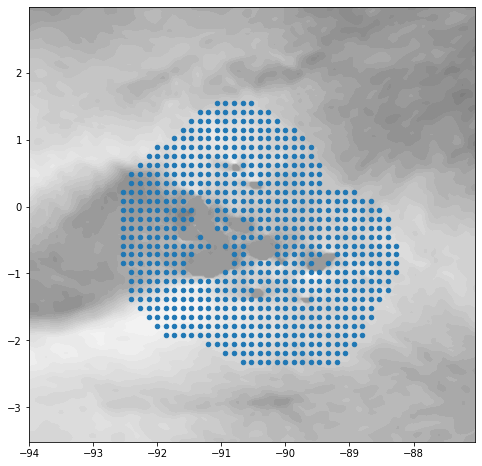

In [7]:
# plot seeding locations

fig, ax = plt.subplots(figsize=(8,8))

levels = np.linspace(-1, 1, 41)
fig = ax.contourf(lon,lat,LandMask,       
                 levels = levels,    
                 cmap='Greys',       
                 extend='both',      
                 origin='lower')     
ax.scatter(startlon,startlat,s=20)


In [7]:
print(len(startlat))

675
